DESCRIPTION

Help a leading mobile brand understand the voice of the customer by analyzing the reviews of their product on Amazon and the topics that customers are talking about. You will perform topic modeling on specific parts of speech. You’ll finally interpret the emerging topics.

Problem Statement: 

A popular mobile phone brand, Lenovo has launched their budget smartphone in the Indian market. The client wants to understand the VOC (voice of the customer) on the product. This will be useful to not just evaluate the current product, but to also get some direction for developing the product pipeline. The client is particularly interested in the different aspects that customers care about. Product reviews by customers on a leading e-commerce site should provide a good view.

Domain: Amazon reviews for a leading phone brand

Analysis to be done: POS tagging, topic modeling using LDA, and topic interpretation

Content: 

Dataset: ‘K8 Reviews v0.2.csv’

Columns:

Sentiment: The sentiment against the review (4,5 star reviews are positive, 1,2 are negative)

Reviews: The main text of the review

Steps to perform:

Discover the topics in the reviews and present it to business in a consumable format. Employ techniques in syntactic processing and topic modeling.

Perform specific cleanup, POS tagging, and restricting to relevant POS tags, then, perform topic modeling using LDA. Finally, give business-friendly names to the topics and make a table for business.

Tasks: 








5> For the topic model, we should  want to include only nouns.

   - Find out all the POS tags that correspond to nouns.
    - Limit the data to only terms with these tags.


6> Lemmatize. 

    - Different forms of the terms need to be treated as one.

    - No need to provide POS tag to lemmatizer for now.

7> Remove stopwords and punctuation (if there are any). 

8> Create a topic model using LDA on the cleaned-up data with 12 topics.

    - Print out the top terms for each topic.

    - What is the coherence of the model with the c_v metric?

9> Analyze the topics through the business lens.

    - Determine which of the topics can be combined.

10> Create topic model using LDA with what you think is the optimal number of topics

    - What is the coherence of the model?

11> The business should  be able to interpret the topics.

    - Name each of the identified topics.

    - Create a table with the topic name and the top 10 terms in each to present to the  business.

do this assignment again by following.
Approach for topic model should be:
1> preprocessing, 
2> configure ur gensim, 
3> optimize ur gensim for right no. of topics and alpha,beta. Tune them and commission it.
4> now u r ready with ur topic model and do analysis what r 10 topics for the document, what r top 10 keywords for the topic,
how is the topic distributed across the document

refer progs:
NLP_Day5_topic-model-07-LDA-newsgroups-CV.ipynb
NLP_Day5_topic-model-06-topic-coherence.ipynb

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# pip install -U gensim
# !pip install pyLDAvis
#!python -m spacy download en 
#!python -m spacy download en
#!pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
# 1> Read the .csv file using Pandas. Take a look at the top few records.
revs0 = pd.read_csv("C:/Users/sharv/Documents/Post Graduate Program In Data Science-PurdueSimpliLearn/Course4-NLP/Projects/K8 Reviews v0.2.csv")
revs0.head()

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentiment,review
0,1,Good but need updates and improvements
1,0,"Worst mobile i have bought ever, Battery is dr..."
2,1,when I will get my 10% cash back.... its alrea...
3,1,Good
4,0,The worst phone everThey have changed the last...


In [3]:
revs0.shape

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(14675, 2)

In [4]:
revs0.sentiment.value_counts(normalize=True)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    0.52552
1    0.47448
Name: sentiment, dtype: float64

In [5]:
revs0.review.isnull()
# No null values present in the dataset.

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0        False
1        False
2        False
3        False
4        False
         ...  
14670    False
14671    False
14672    False
14673    False
14674    False
Name: review, Length: 14675, dtype: bool

In [6]:
revs0.review.sample().values[0]

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'Very good quality good battery 🔋 is very good'

In [7]:
# 2> Normalize casings for the review text and extract the text into a list for easier manipulation.

revs1 = revs0.review.values
len(revs1)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


14675

In [8]:
revs1[:5]

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['Good but need updates and improvements',
       "Worst mobile i have bought ever, Battery is draining like hell, backup is only 6 to 7 hours with internet uses, even if I put mobile idle its getting discharged.This is biggest lie from Amazon & Lenove which is not at all expected, they are making full by saying that battery is 4000MAH & booster charger is fake, it takes at least 4 to 5 hours to be fully charged.Don't know how Lenovo will survive by making full of us.Please don;t go for this else you will regret like me.",
       'when I will get my 10% cash back.... its already 15 January..',
       'Good',
       'The worst phone everThey have changed the last phone but the problem is still same and the amazon is not returning the phone .Highly disappointing of amazon'],
      dtype=object)

The review contains- numbers, % signs, ...., /, !, @

In [9]:
revs_lower = [sh.lower() for sh in revs1]
#revs_lower[:5]
revs_lower[4130]

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'i am not able to take screenshots and screen mirror to my smart tv, i feel dual cam is for name sake clarity not upto the mark. for me just ordinary phone. no ir facilities. suggest me to return the product.'

In [10]:
# 3> Tokenize the reviews using NLTKs word_tokenize function.

from nltk.tokenize import word_tokenize
print(word_tokenize(revs_lower[0]))


['good', 'but', 'need', 'updates', 'and', 'improvements']


C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
revs_tokens = [word_tokenize(sent) for sent in revs_lower]
print(revs_tokens[9203])

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['does', "n't", 'have', 'call', 'recording', '.', 'cast', 'screen', 'not', 'working', '.']


In [12]:
# Remove stop words and punctuations

from nltk.corpus import stopwords
from string import punctuation

stop_nltk = stopwords.words("english")
stop_punct = list(punctuation)

stop_nltk.remove("no")
stop_nltk.remove("have")
stop_nltk.remove("not")
stop_nltk.remove("don")
stop_nltk.remove("won")
stop_nltk.remove("won't")
stop_nltk.remove("don't")
stop_nltk.remove("doesn't")
stop_nltk.remove("doesn")
stop_nltk.remove("does")
stop_nltk.remove("do")
stop_nltk.remove('wouldn')
stop_nltk.remove("wouldn't")
stop_nltk.remove('shan')
stop_nltk.remove("shan't")
stop_nltk.remove('shouldn')
stop_nltk.remove("shouldn't")
stop_nltk.remove('aren')
stop_nltk.remove("aren't")
stop_nltk.remove('couldn')
stop_nltk.remove("couldn't")
stop_nltk.remove('didn')
stop_nltk.remove("didn't")
stop_nltk.remove('mightn')
stop_nltk.remove("mightn't")
stop_nltk.remove('mustn')
stop_nltk.remove("mustn't")
print(stop_nltk)
print(punctuation)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'has', 'had', 'having', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'wil

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
"no" in stop_nltk

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


False

In [14]:

stop_final =  stop_nltk + stop_punct + ["'s","'m"]

def del_stop(sent):
    return [term for term in sent if term not in stop_final]

del_stop(revs_tokens[9203])

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['does',
 "n't",
 'have',
 'call',
 'recording',
 'cast',
 'screen',
 'not',
 'working']

In [15]:
revs_clean = [del_stop(sent) for sent in revs_tokens]
revs_clean = [" ".join(sent) for sent in revs_clean]
revs_clean[9203]

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"does n't have call recording cast screen not working"

In [16]:
#regex = r"[.]{2,3,4,5}"
#subst = ""
#revs_clean1 = re.sub(regex, subst, revs_clean)
#revs_clean1[12417]
#patterns=["..","..."]
#for i in patterns:
#    revs_clean1=re.sub(i,"",revs_clean)
#    print(revs_clean1[12417])

# Below code will delete '.' occuring multiple times and will delete '-' occuring multiple times.Also delete emojis.

revs_clean1 = [re.sub(r'[.]{1,}', '', file) for file in revs_clean]
revs_clean2 = [re.sub(r'[--]{2}', '', file) for file in revs_clean1]
revs_clean3= [re.sub('[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)]+','',file)for file in revs_clean2]

revs_clean3[9203]

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"does n't have call recording cast screen not working"

In [17]:
# below code will show the review written in different language into english.

def preprocess2(raw_text):
    stopword_set = set(stopwords.words("english"))
    stopword_set.discard("not")
    stopword_set.discard("no")
    stopword_set.discard("don")
    stopword_set.discard("won")
    stopword_set.discard("won't")
    stopword_set.discard("don't")
    stopword_set.discard("doesn't")
    stopword_set.discard("does")
    stopword_set.discard("doesn")
    stopword_set.discard("do")
    stopword_set.discard('wouldn')
    stopword_set.discard("wouldn't")
    stopword_set.discard('shan')
    stopword_set.discard("shan't")
    stopword_set.discard('shouldn')
    stopword_set.discard("shouldn't")
    stopword_set.discard('aren')
    stopword_set.discard("aren't")
    stopword_set.discard('couldn')
    stopword_set.discard("couldn't")
    stopword_set.discard('didn')
    stopword_set.discard("didn't")
    stopword_set.discard('mightn')
    stopword_set.discard("mightn't")
    stopword_set.discard('mustn')
    stopword_set.discard("mustn't")
    stopword_set.discard("have")
    return " ".join([i for i in re.sub(r'[^a-zA-Z\s]', "", raw_text).lower().split() if i not in stopword_set])

revs_clean4 = [preprocess2(raw_text) for raw_text in revs_clean3]
revs_clean4 = ["".join(raw_text) for raw_text in revs_clean4]
#revs_clean4[9203]
#revs_clean4[13513]
# revs_clean4[8198]
#revs_clean4[8130]
#revs_clean4[4451]
#revs_clean4[2659]
#revs_clean4[2420]
#revs_clean4[1944]
#revs_clean4[303]
#revs_clean4[12042]
#revs_clean4[12038]
#revs_clean4[11552]
#revs_clean4[11461]
#revs_clean4[10590]
#revs_clean4[8988]
revs_clean4[7867]

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'performance bhi theek hai'

In [18]:
# 4> Perform parts-of-speech tagging on each sentence using the NLTK POS tagger.

def process_content():
    try:
        for i in revs_clean4[:5]:
            revs_tokens1 = nltk.word_tokenize(i)
            tagged = nltk.pos_tag(revs_tokens1)
            print(tagged)

    except Exception as e:
        print(str(e))


process_content()

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('good', 'JJ'), ('need', 'NN'), ('updates', 'NNS'), ('improvements', 'NNS')]
[('worst', 'RB'), ('mobile', 'RB'), ('have', 'VBP'), ('bought', 'VBN'), ('ever', 'RB'), ('battery', 'RB'), ('draining', 'VBG'), ('like', 'IN'), ('hell', 'NN'), ('backup', 'NN'), ('hours', 'NNS'), ('internet', 'VBP'), ('uses', 'NNS'), ('even', 'RB'), ('put', 'VBP'), ('mobile', 'JJ'), ('idle', 'JJ'), ('getting', 'VBG'), ('dischargedthis', 'JJ'), ('biggest', 'JJS'), ('lie', 'NN'), ('amazon', 'NN'), ('lenove', 'IN'), ('not', 'RB'), ('expected', 'VBN'), ('making', 'VBG'), ('full', 'JJ'), ('saying', 'VBG'), ('battery', 'NN'), ('mah', 'NN'), ('booster', 'NN'), ('charger', 'NN'), ('fake', 'VBP'), ('takes', 'VBZ'), ('least', 'JJS'), ('hours', 'NNS'), ('fully', 'RB'), ('chargeddo', 'VBP'), ('nt', 'NNS'), ('know', 'VBP'), ('lenovo', 'JJ'), ('survive', 'JJ'), ('making', 'VBG'), ('full', 'JJ'), ('usplease', 'NN'), ('don', 'NN'), ('go', 'VBP'), ('else', 'RB'), ('regret', 'VBP'), ('like', 'IN')]
[('get', 'VB'), ('cash', 'NN

In [19]:
# converting list to dataframe
#from pandas import DataFrame
#df = DataFrame (revs_clean4,columns=['Review'])
#df.shape

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
import en_core_web_sm
#nlp = en_core_web_sm.load()
spacy.load('en_core_web_sm')

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# To further remove noise from the text we can use lemmatization from the spaCy library. It reduces any given word to its 
# base form thereby reducing multiple forms of a word to a single word.

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, tags=['NOUN']): # filter noun and adjective
    # , 'ADJ'
        output = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            output.append([token.lemma_ for token in doc if token.pos_ in tags])
        return output

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [22]:
# Let’s tokenize the reviews and then lemmatize the tokenized reviews.

tokenized_reviews = pd.Series(revs_clean4).apply(lambda x: x.split())
print(tokenized_reviews[1])

['worst', 'mobile', 'have', 'bought', 'ever', 'battery', 'draining', 'like', 'hell', 'backup', 'hours', 'internet', 'uses', 'even', 'put', 'mobile', 'idle', 'getting', 'dischargedthis', 'biggest', 'lie', 'amazon', 'lenove', 'not', 'expected', 'making', 'full', 'saying', 'battery', 'mah', 'booster', 'charger', 'fake', 'takes', 'least', 'hours', 'fully', 'chargeddo', 'nt', 'know', 'lenovo', 'survive', 'making', 'full', 'usplease', 'don', 'go', 'else', 'regret', 'like']


C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
reviews_2 = lemmatization(tokenized_reviews)
print(reviews_2[1]) # print lemmatized review

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['battery', 'hour', 'internet', 'idle', 'lie', 'hour', 'usplease', 'regret']


In this step, only nouns will be used for creating topics by using the LDA method. Again, our purpose is to find hidden patterns in reviews. 

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


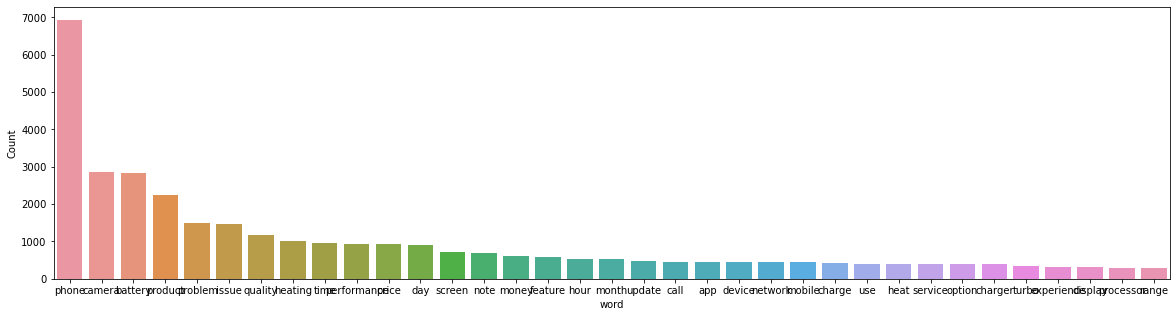

In [24]:
# As you can see, we have not just lemmatized the words but also filtered only nouns. Let’s de-tokenize the lemmatized reviews and plot the most 
# common words.
from pandas import DataFrame
df = DataFrame (revs_clean4,columns=['Review'])

from nltk import FreqDist
import seaborn as sns

# function to plot most frequent terms
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()

    fdist = FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
    d = words_df.nlargest(columns="count", n = terms) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    plt.show()

reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))

df['reviews'] = reviews_3

freq_words(df['reviews'], 35)

It seems that now most frequent terms in our data are relevant. We can now go ahead and start building our topic model.

In [25]:
# Building an LDA model
# We will start by creating the term dictionary of our corpus, where every unique term is assigned an index
import gensim
from gensim import corpora
dictionary = corpora.Dictionary(reviews_2)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Then we will convert the list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model with num_topics=12
lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=12, random_state=100,
                chunksize=1000, passes=50)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
# Let’s print out the topics that our LDA model has learned.
# The above LDA model is built with 12 different topics where each topic is a combination of keywords and each keyword contributes a certain weightage 
# to the topic
lda_model.print_topics()

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.324*"phone" + 0.169*"battery" + 0.038*"hour" + 0.033*"charge" + 0.033*"day" + 0.021*"issue" + 0.020*"life" + 0.017*"drain" + 0.017*"month" + 0.016*"turbo"'),
 (1,
  '0.463*"product" + 0.081*"service" + 0.039*"customer" + 0.027*"system" + 0.021*"center" + 0.020*"care" + 0.019*"month" + 0.017*"delivery" + 0.016*"warranty" + 0.016*"purchase"'),
 (2,
  '0.099*"camera" + 0.038*"processor" + 0.036*"mode" + 0.032*"note" + 0.031*"video" + 0.029*"depth" + 0.022*"android" + 0.020*"photo" + 0.019*"k" + 0.018*"thing"'),
 (3,
  '0.158*"phone" + 0.109*"feature" + 0.099*"device" + 0.049*"heat" + 0.038*"budget" + 0.026*"power" + 0.026*"side" + 0.025*"buy" + 0.024*"specification" + 0.023*"piece"'),
 (4,
  '0.179*"money" + 0.124*"mobile" + 0.064*"value" + 0.062*"charger" + 0.059*"speaker" + 0.051*"waste" + 0.039*"expectation" + 0.033*"turbo" + 0.021*"mark" + 0.020*"company"'),
 (5,
  '0.269*"time" + 0.101*"phone" + 0.074*"lot" + 0.047*"work" + 0.036*"signal" + 0.025*"message" + 0.025*"buying" 

Topic 0 includes words like “time”, “device”, “return”,"call","customer","option","support","contact","purchase" and “box”, sounds like a topic related to customer care. Topic 8 includes words like “battery”, “phone”, “day”,"hour","charge","poor","charger","time","turbo" and “full”, it is definite a phone battery related topic. Topic 2 includes words like “good”, “phone”, “product”,"camera","battery","awesome","performance","quality","amazing" and “performance”, sounds like a positive points about phone related topic. And so on.
With LDA, we can see that different document with different topics, and the discriminations are obvious.

Topics Visualization
To visualize our topics in a 2-dimensional space we will use the pyLDAvis library. This visualization is interactive in nature and displays topics along with the most relevant words.

In [29]:
# Visualize the topics
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.274071 -0.085051       1        1  18.862723
2     -0.069195  0.323251       2        1  12.886416
9      0.220176  0.163253       3        1  11.358512
8     -0.161439  0.090702       4        1   8.593270
1     -0.155534 -0.207913       5        1   6.917859
3      0.169063 -0.032461       6        1   6.805039
7      0.167681 -0.040545       7        1   6.418927
11    -0.032488 -0.130482       8        1   6.194188
6     -0.182116  0.048661       9        1   5.992287
5      0.102823 -0.035773      10        1   5.542238
10    -0.188152  0.021773      11        1   5.238858
4     -0.144890 -0.115415      12        1   5.189684, topic_info=        Term         Freq        Total Category  logprob  loglift
46   product  2162.000000  2162.000000  Default  30.0000  30.0000
12     phone  6766.000000  6766.000000  Default  29.0000  29.0000
54    camera  2786.000000  2786.000000  Default  28.0000  28.0000
13   problem  1460.000000  1460.000000  Default  27.0000  27.0000
68     issue  1419.000000  1419.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
52   speaker   207.775829   276.092036  Topic12  -2.8246   2.6742
31   charger   216.271712   382.294985  Topic12  -2.7846   2.3888
396  company    71.176392   114.000889  Topic12  -3.8959   2.4875
152    turbo   116.765492   317.990694  Topic12  -3.4009   1.9566
351      box    34.480512   115.914105  Topic12  -4.6207   1.7460

[507 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
1148      7  0.943961     access
278       1  0.962642  accessory
2472      5  0.895756   activity
1328     10  0.965561      alarm
804       3  0.904692       alot
...     ...       ...        ...
173      10  0.798555       work
196      11  0.980068    working
26       10  0.988832       year
849       1  0.956805  yesterday
2204      3  0.951621       zoom

[521 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 10, 9, 2, 4, 8, 12, 7, 6, 11, 5])

Saliency: a measure of how much the term tells you about the topic.
Relevance: a weighted average of the probability of the word given the topic and the word given the topic normalized by the probability of the topic.
The size of the bubble measures the importance of the topics, relative to the data.
When we have 12 topics, we can see certain topics are clustered together, this indicates the similarity between topics. 


First, we got the most salient terms, means terms mostly tell us about what’s going on relative to the topics. We can also look at individual topic.

In [30]:
#First, we got the most salient terms, means terms mostly tell us about what’s going on relative to the topics. We can also look at individual topic.
#Visualizing 4 topics:
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model1 = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100,
                chunksize=1000, passes=50)
lda_model1.print_topics()

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.187*"phone" + 0.086*"battery" + 0.060*"problem" + 0.059*"issue" + 0.041*"heating" + 0.037*"day" + 0.025*"time" + 0.021*"month" + 0.021*"hour" + 0.019*"network"'),
 (1,
  '0.213*"product" + 0.037*"service" + 0.032*"update" + 0.029*"software" + 0.028*"return" + 0.022*"delivery" + 0.020*"customer" + 0.017*"replacement" + 0.015*"system" + 0.014*"support"'),
 (2,
  '0.117*"camera" + 0.100*"phone" + 0.049*"quality" + 0.038*"price" + 0.037*"performance" + 0.029*"battery" + 0.019*"feature" + 0.019*"device" + 0.018*"note" + 0.013*"processor"'),
 (3,
  '0.056*"screen" + 0.035*"call" + 0.032*"mobile" + 0.028*"app" + 0.028*"option" + 0.020*"speaker" + 0.018*"money" + 0.015*"time" + 0.014*"glass" + 0.013*"waste"')]

In [31]:
# Visualize the topics
#import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis1 = pyLDAvis.gensim.prepare(lda_model1, doc_term_matrix, dictionary)
vis1

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.183062 -0.016377       1        1  33.237511
0     -0.235424  0.102536       2        1  32.786210
3      0.131715 -0.295695       3        1  19.166062
1      0.286772  0.209536       4        1  14.810217, topic_info=            Term         Freq        Total Category  logprob  loglift
46       product  2129.000000  2129.000000  Default  30.0000  30.0000
12         phone  6384.000000  6384.000000  Default  29.0000  29.0000
54        camera  2617.000000  2617.000000  Default  28.0000  28.0000
13       problem  1337.000000  1337.000000  Default  27.0000  27.0000
68         issue  1311.000000  1311.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
176        model    70.766764   131.482319   Topic4  -4.9503   1.2904
198  expectation    66.583558   127.723703   Topic4  -5.0113   1.2584
124          guy    53.659754    82.096540   Topic4  -5.2271   1.4846
41          time   116.588236   866.456390   Topic4  -4.4511  -0.0959
295          bug    51.590294    75.125135   Topic4  -5.2664   1.5340

[186 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
10        4  0.987781    amazon
127       1  0.995691   android
100       1  0.145801       app
100       3  0.851290       app
201       1  0.990830      atmo
...     ...       ...       ...
25        4  0.995302  warranty
208       3  0.997944     waste
117       4  0.971720    weight
173       1  0.299006      work
173       3  0.699369      work

[180 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

What is the Dominant topic and its percentage contribution in each document?

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, you will know which document belongs predominantly to which topic.

In [33]:
# taking model with 4 topics is lda_model

def format_topics_sentences(ldamodel=None, corpus=doc_term_matrix, texts=reviews_2):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model1, corpus=doc_term_matrix, texts=reviews_2)
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.7368,"camera, phone, quality, price, performance, ba...","[need, improvement]"
1,1,0.0,0.9162,"phone, battery, problem, issue, heating, day, ...","[battery, hour, internet, idle, lie, hour, usp..."
2,2,2.0,0.6249,"camera, phone, quality, price, performance, ba...",[cash]
3,3,0.0,0.2500,"phone, battery, problem, issue, heating, day, ...",[]
4,4,0.0,0.7430,"phone, battery, problem, issue, heating, day, ...","[phone, everthey, phone, problem, phone, amazon]"
5,5,3.0,0.6146,"screen, call, mobile, app, option, speaker, mo...",[money]
6,6,2.0,0.4772,"camera, phone, quality, price, performance, ba...","[phone, heat, allot, reason, hate, note]"
7,7,2.0,0.7286,"camera, phone, quality, price, performance, ba...","[battery, level]"
8,8,0.0,0.7440,"phone, battery, problem, issue, heating, day, ...","[problem, phone, hanging, problem, service, st..."
9,9,2.0,0.5377,"camera, phone, quality, price, performance, ba...","[lot, glitch, thing, option]"


The most representative sentence for each topic
Sometimes you want to get samples of sentences that most represent a given topic. This code gets the most exemplar sentence for each topic.

In [34]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9599,"phone, battery, problem, issue, heating, day, time, month, hour, network","[phone, heating, iron, box, minute, use, phone, time, battery, life, month, life, battery, hour,..."
1,1.0,0.9464,"product, service, update, software, return, delivery, customer, replacement, system, support","[system, update, system, update, check, update, system, purchase, date, product, check, official..."
2,2.0,0.9617,"camera, phone, quality, price, performance, battery, feature, device, note, processor","[phone, lot, probleam, phone, feature, camera, phone, camera, depth, mode, photo, light, camera,..."
3,3.0,0.9421,"screen, call, mobile, app, option, speaker, money, time, glass, waste","[screen, display, attach, glass, air, gap, surround, screen, glass, mobile, pay, bill]"


Frequency Distribution of Word Counts in Documents:
When working with a large number of documents, you want to know how big the documents are as a whole and by topic. Let’s plot the document word counts distribution.

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


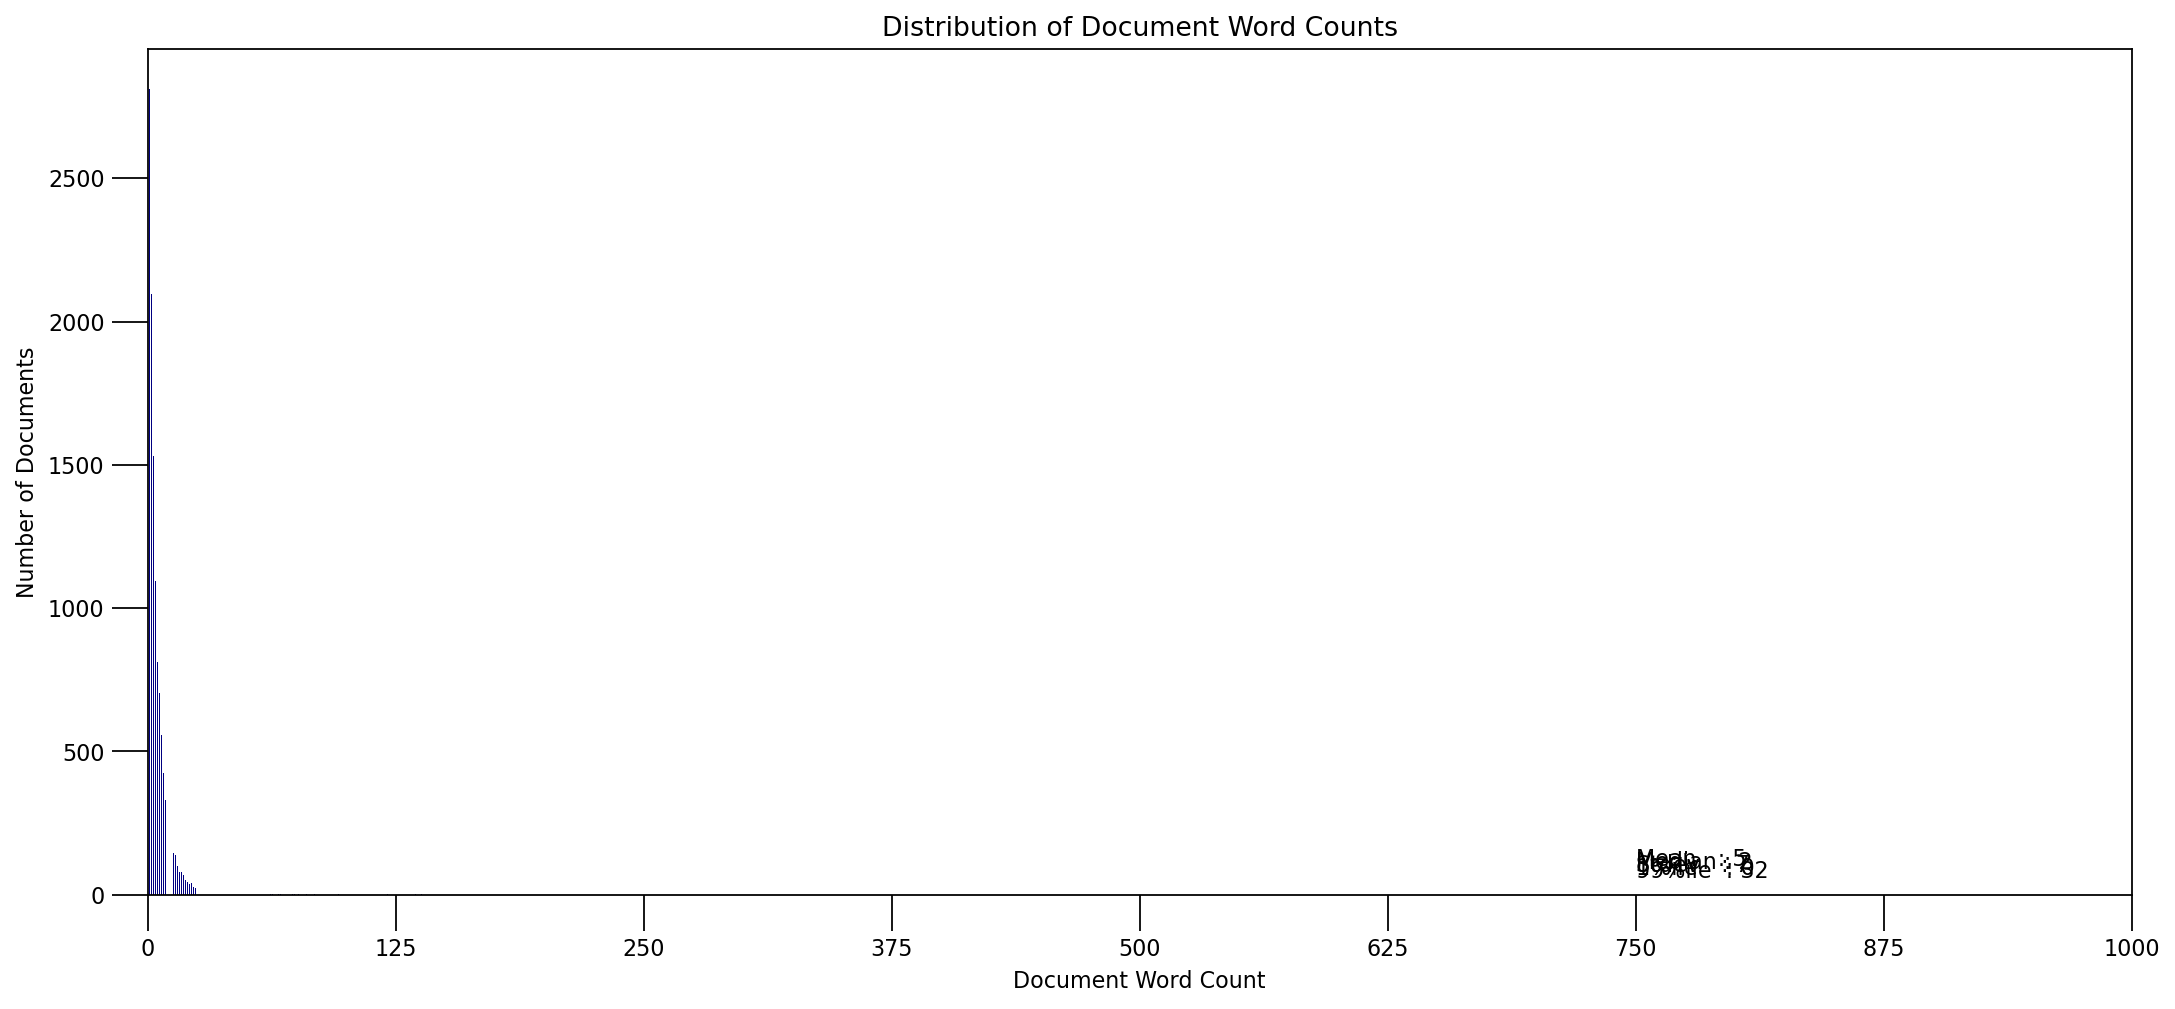

In [35]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=12))
plt.show()

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 0.98, 'Distribution of Document Word Counts by Dominant Topic')

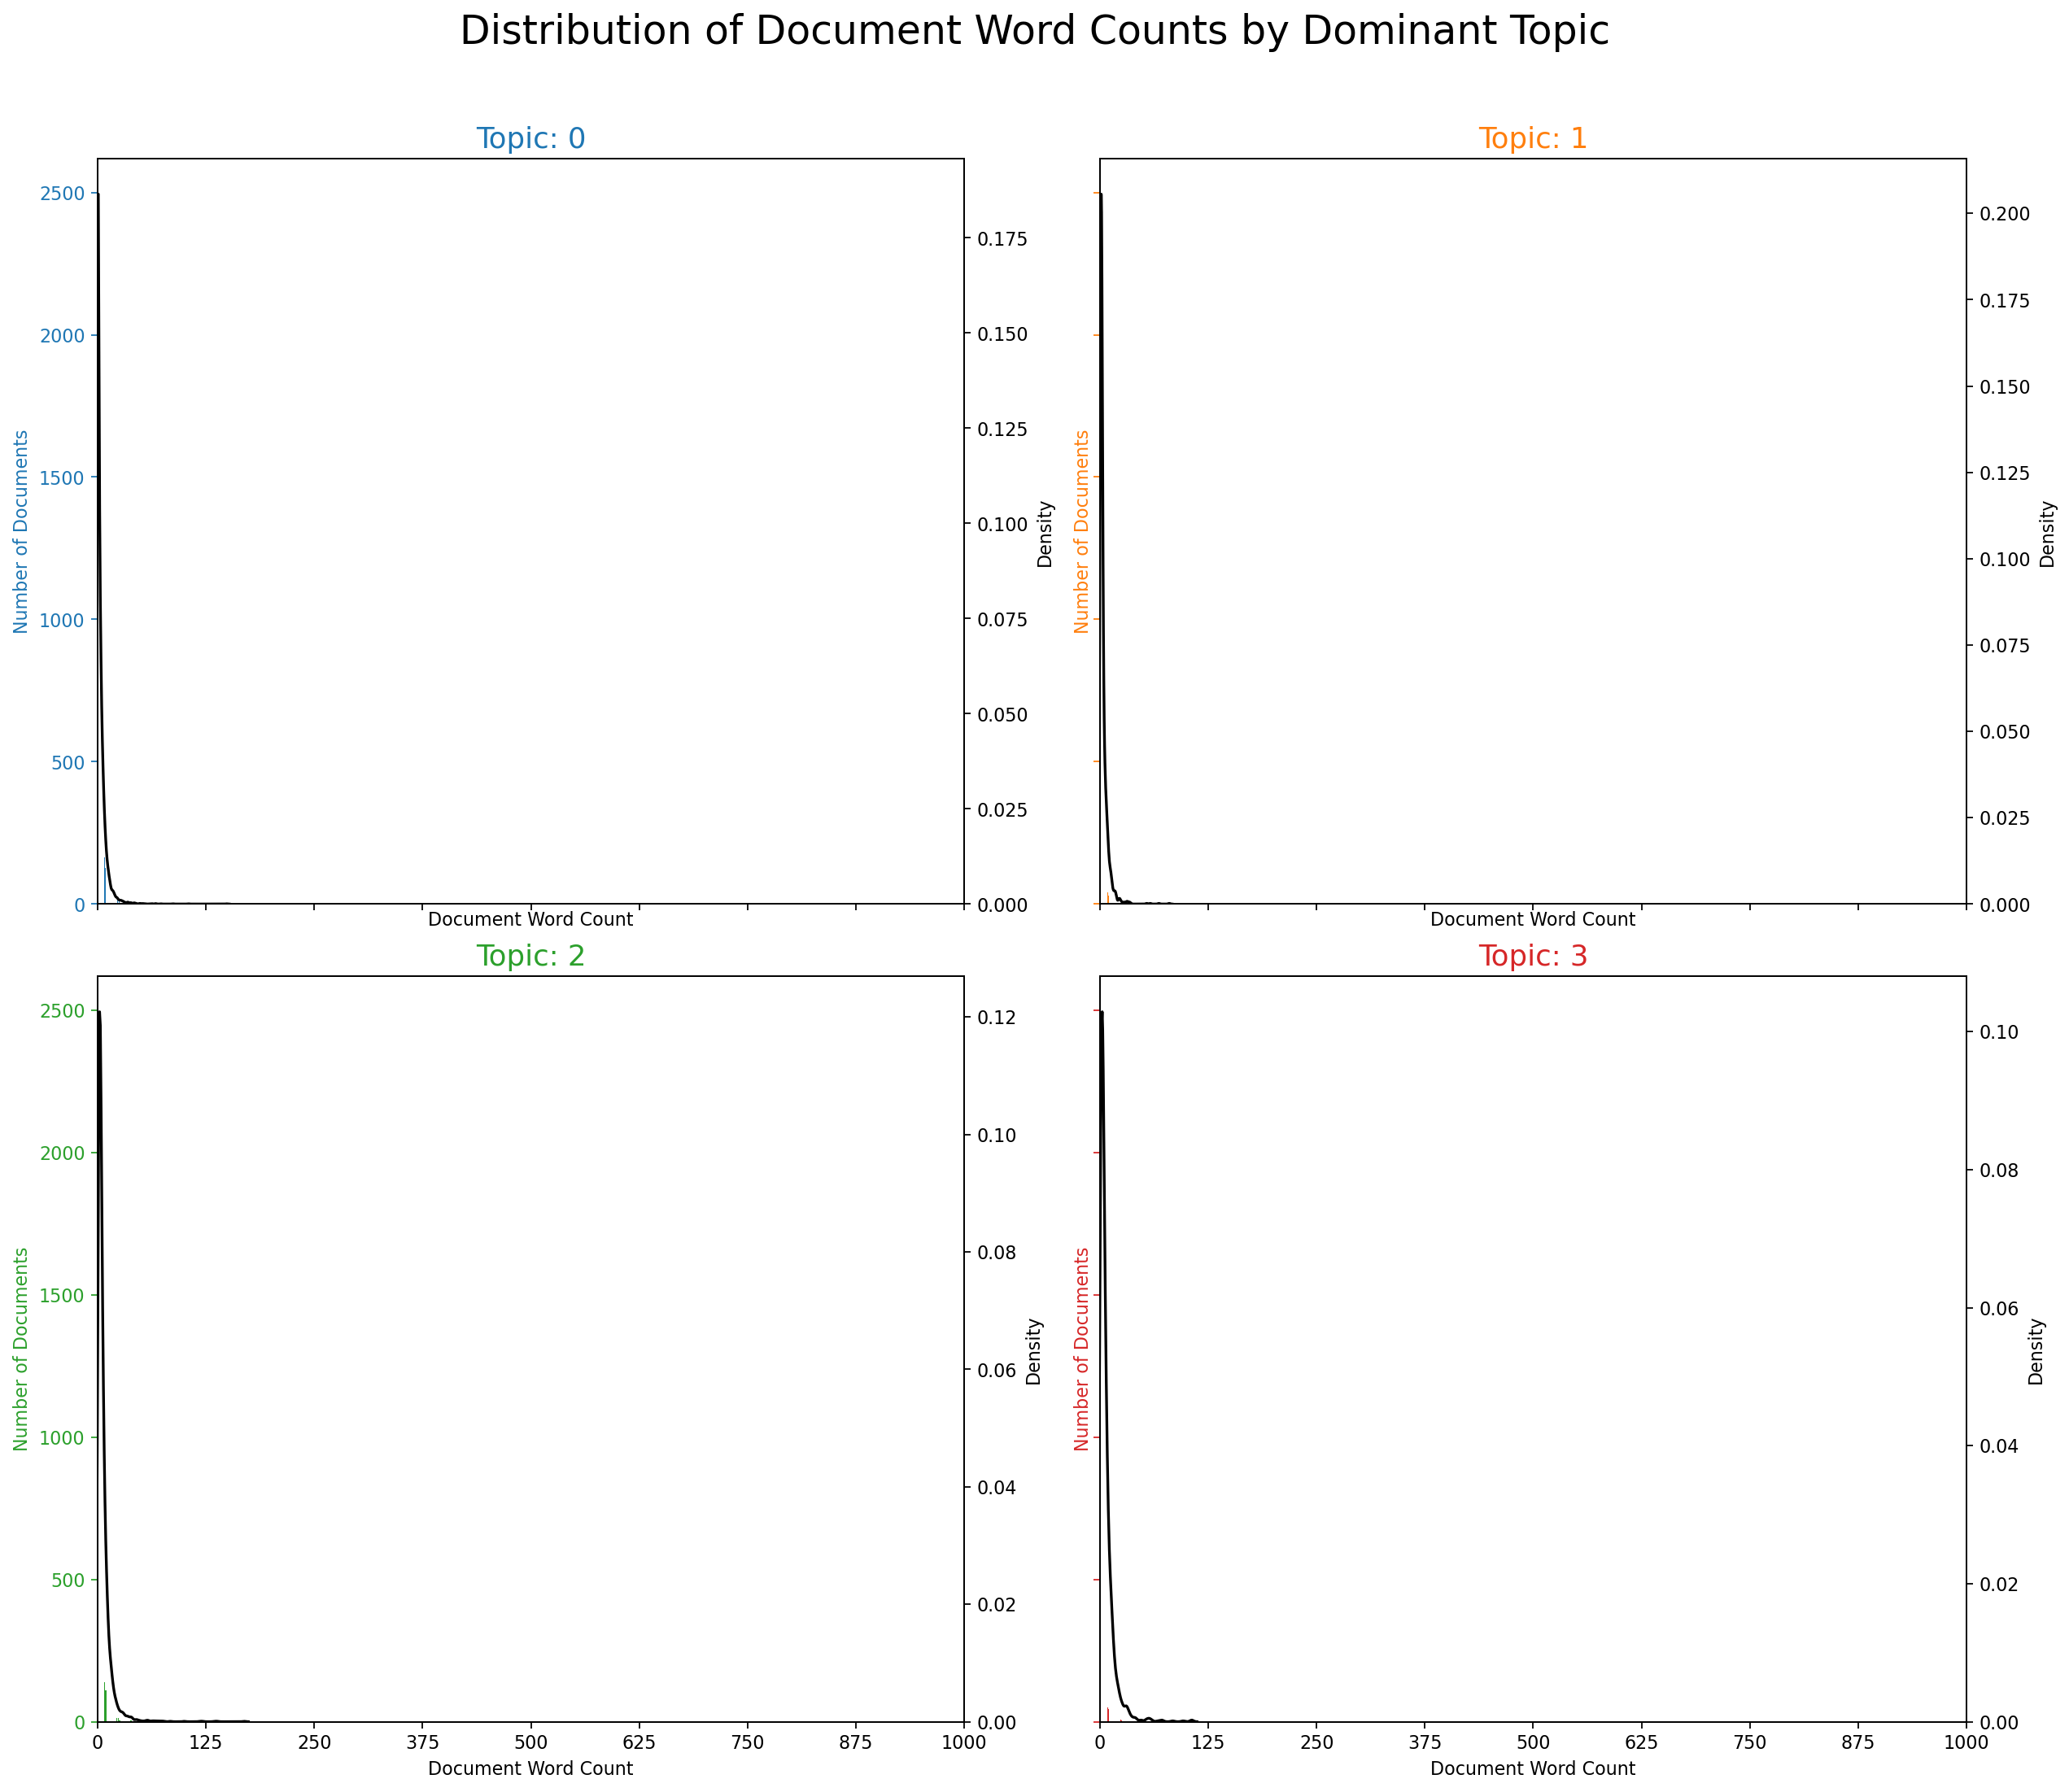

In [36]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)

Word Clouds of Top N Keywords in Each Topic:
Though you’ve already seen what are the topic keywords in each topic, a word cloud with the size of the words proportional to the weight is a pleasant sight. The coloring of the topics I’ve taken here is followed in the subsequent plots as well.

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


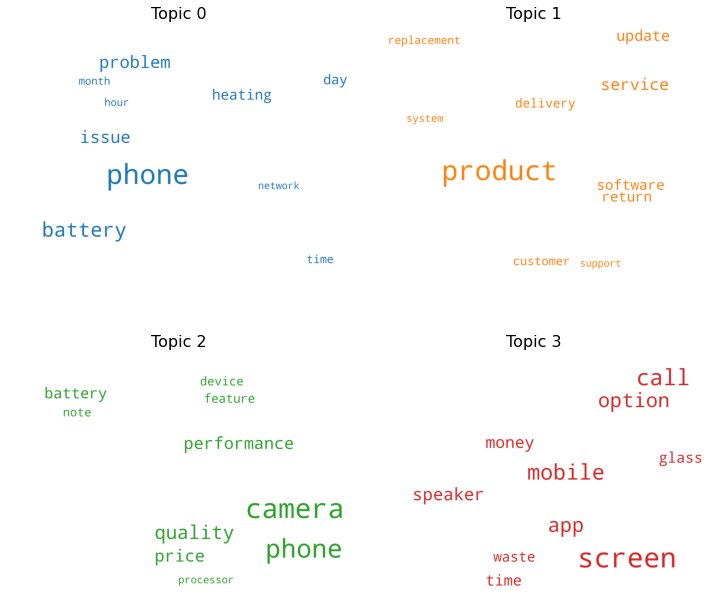

In [37]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=revs_clean4,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model1.show_topics(formatted=False) # num_topics=4, num_words=10,
#topics=lda_model.show_topics(num_topics=-1, formatted=False)[i] = lda_model.show_topic(12 - i - 1)
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=200)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

Word Counts of Topic Keywords:
When it comes to the keywords in the topics, the importance (weights) of the keywords matters. Along with that, how frequently the words have appeared in the documents is also interesting to look.

Let’s plot the word counts and the weights of each keyword in the same chart.

You want to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
C:\Users\sharv\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\sharv\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\sharv\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
C:\Users\sharv\anaconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator


Text(0.5, 1.05, 'Word Count and Importance of Topic Keywords')

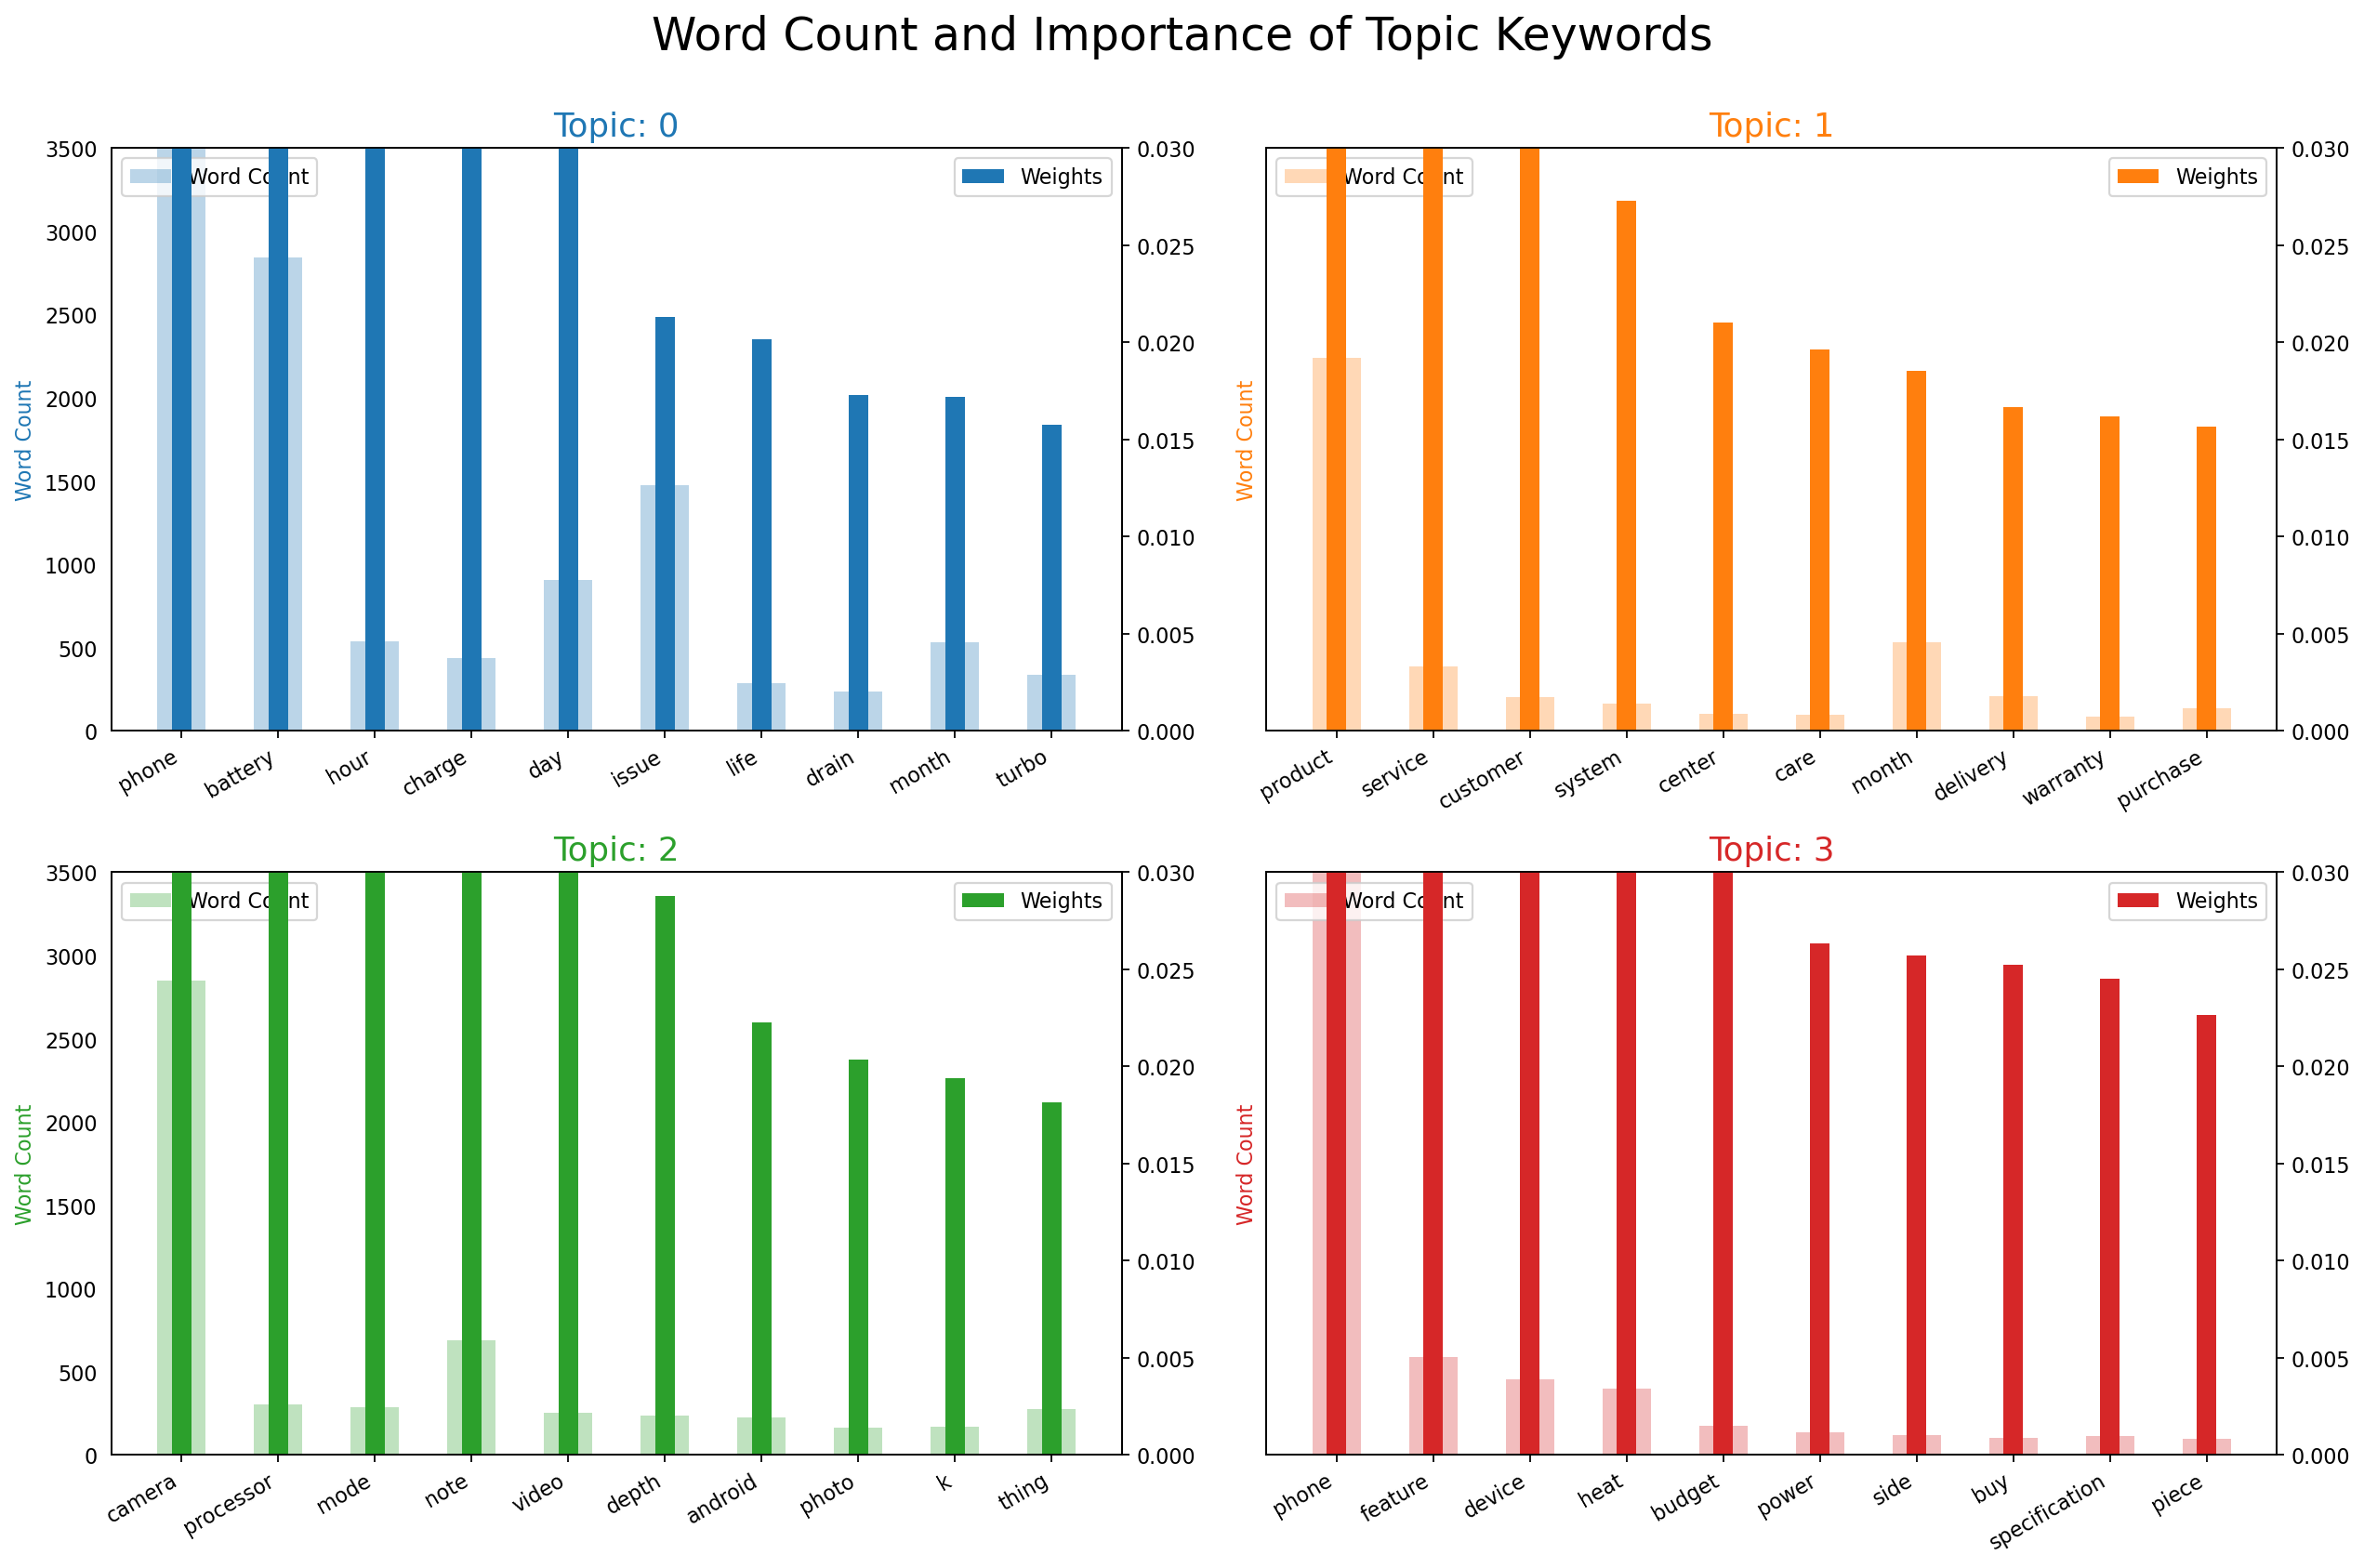

In [38]:
from collections import Counter
topics = lda_model.show_topics(num_topics=12,formatted=False)
data_flat = [w for w_list in reviews_2 for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    

Sentence Chart Colored by Topic:
 Each word in the document is representative of one of the 12 topics. Let’s color each word in the given documents by the topic id it is attributed to.
The color of the enclosing rectangle is the topic assigned to the document.   

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: too many values to unpack (expected 3)

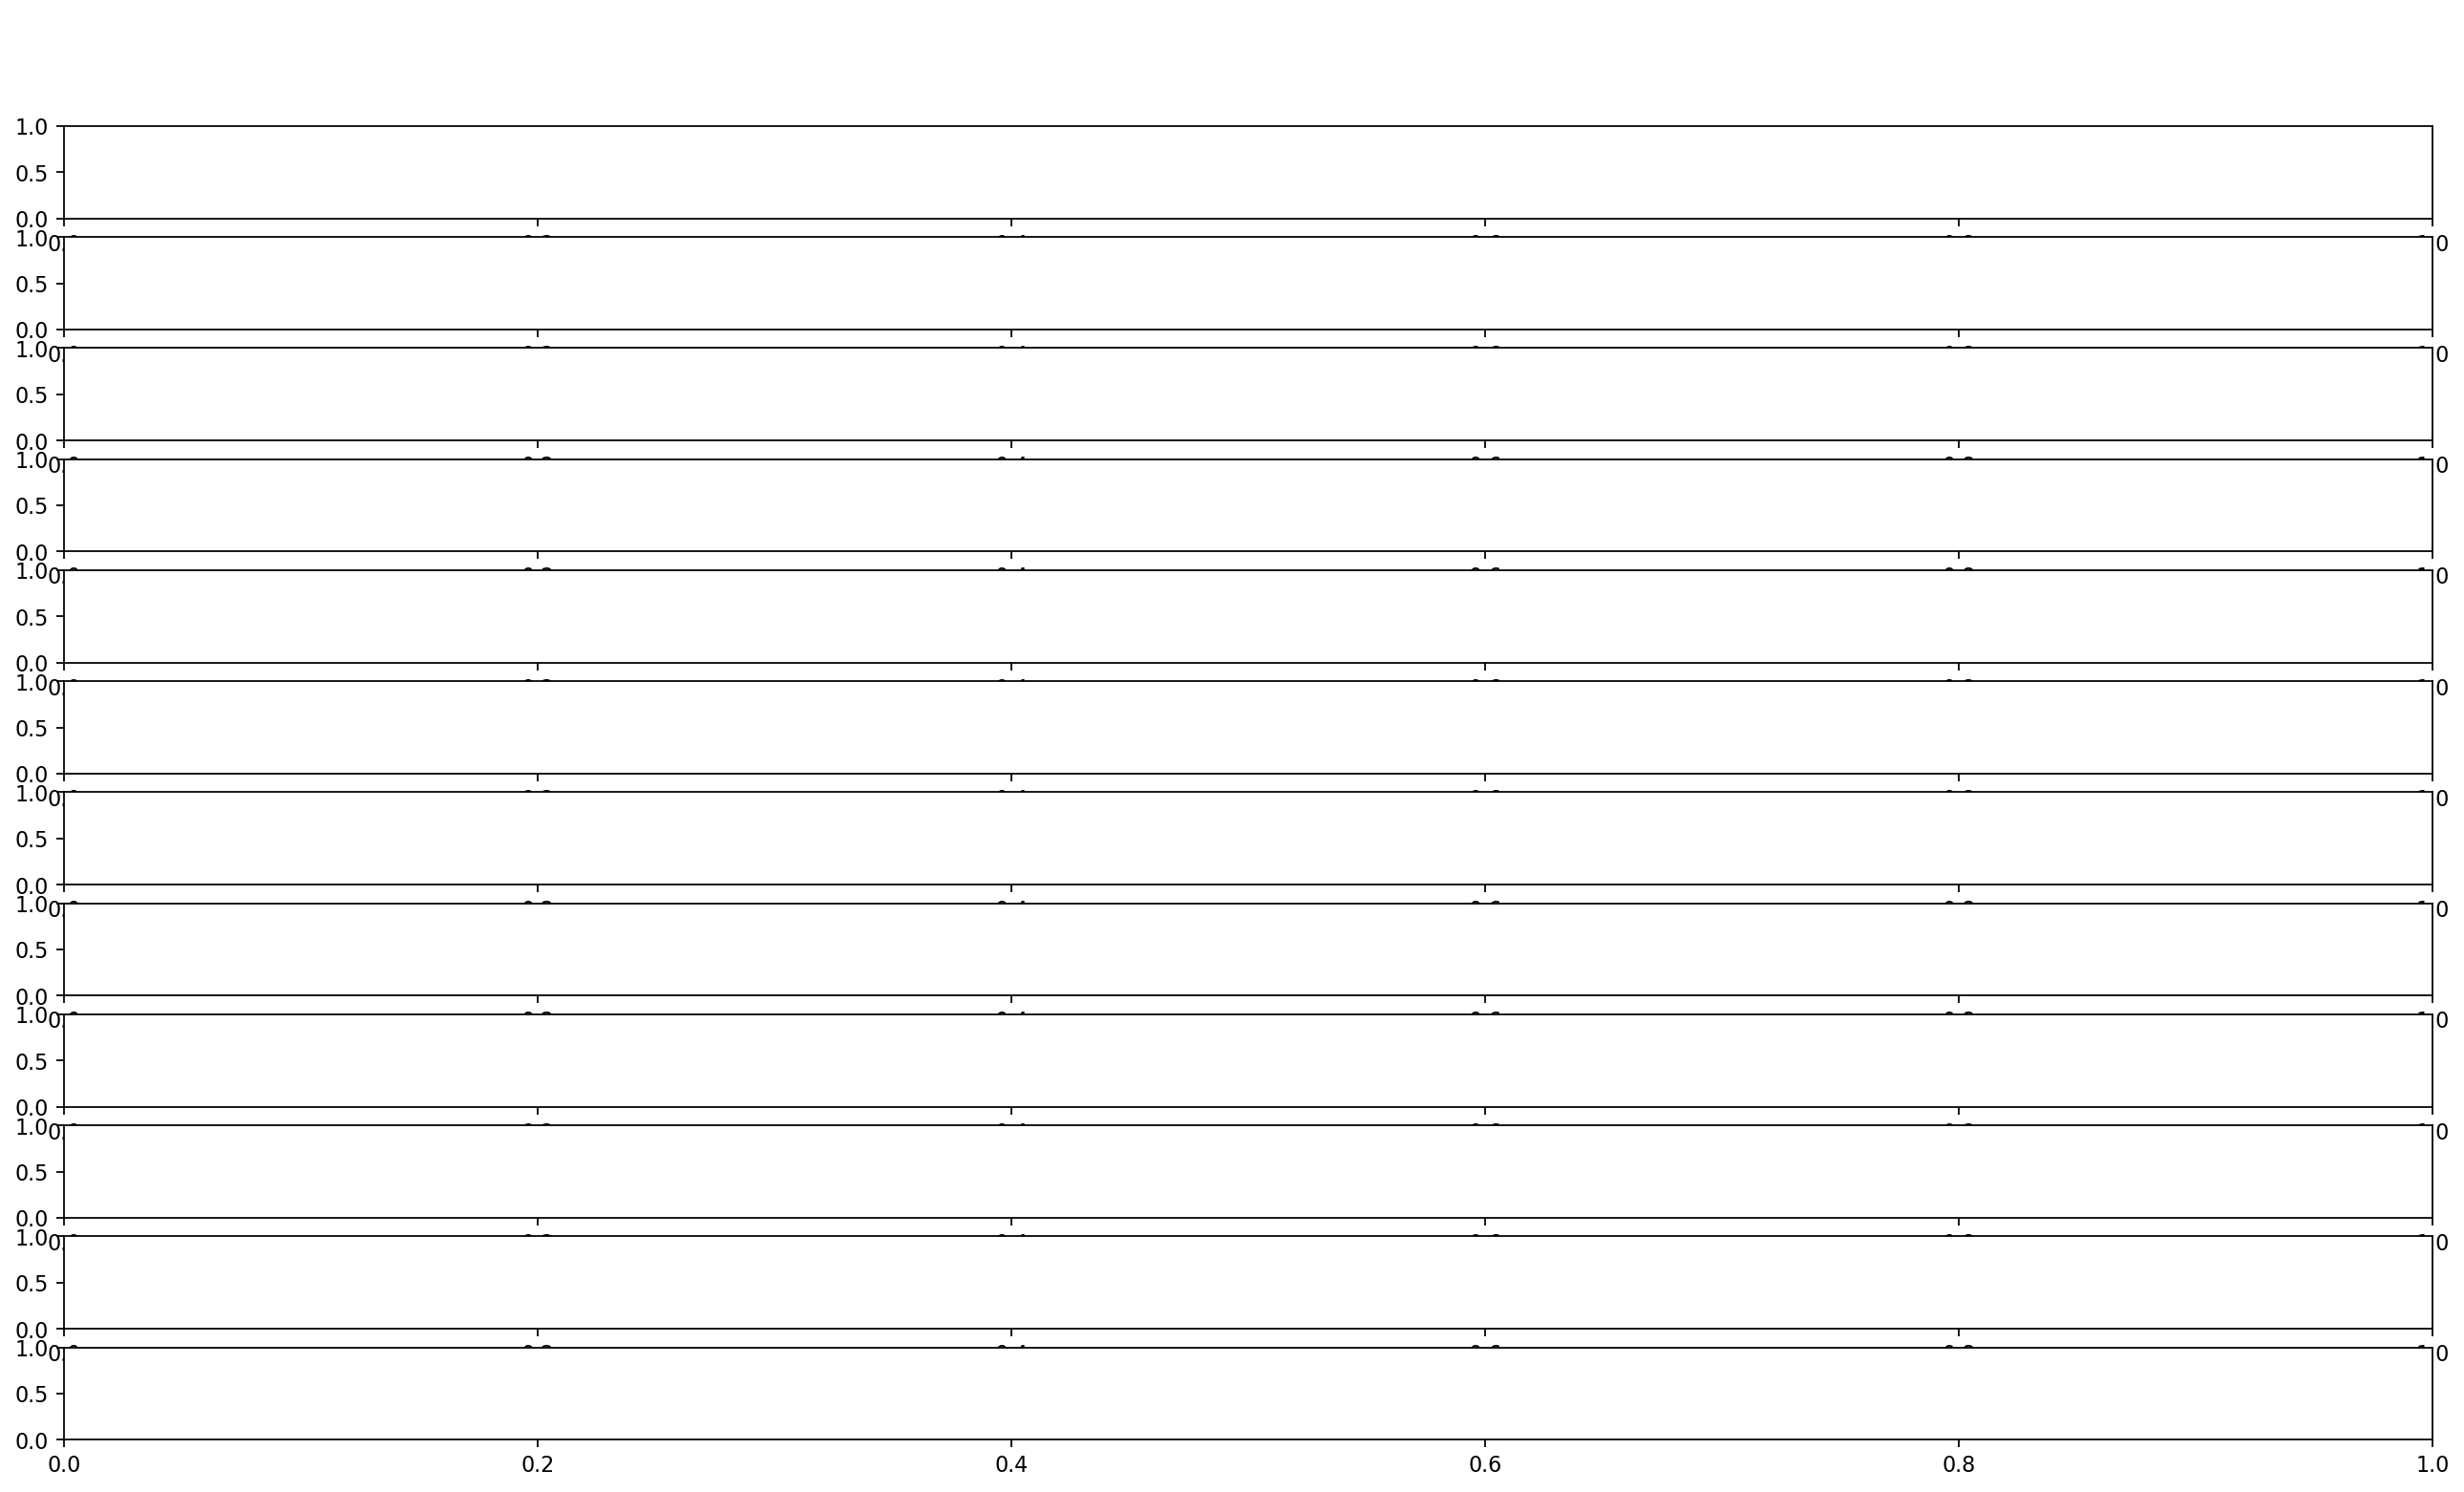

In [44]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model1, corpus=doc_term_matrix, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            #topic_percs, wordid_topics, wordid_phivalues = lda_model.get_document_topics(corp_cur)
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()
sentences_chart()    

What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.

In [45]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=doc_term_matrix, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: too many values to unpack (expected 3)

Let’s make two plots:

The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'df_dominant_topic_in_each_doc' is not defined

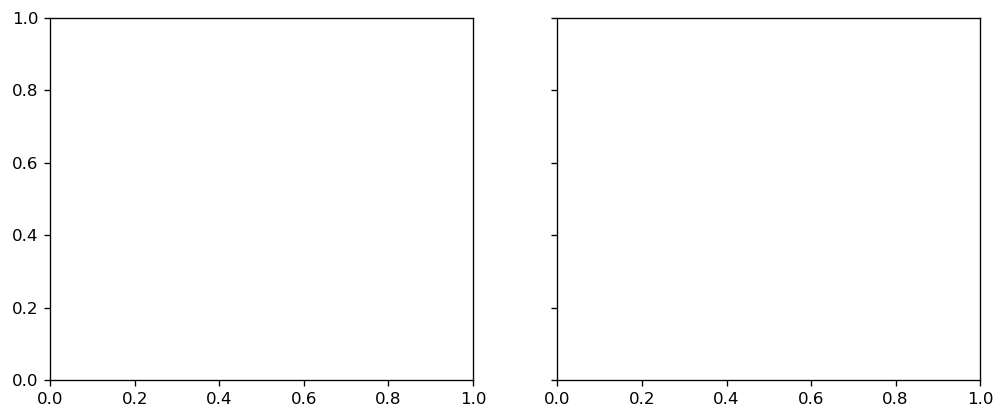

In [119]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))
plt.show()

t-SNE Clustering Chart:
Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [121]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[doc_term_matrix]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: cannot unpack non-iterable int object

To me, The topic model with three groups is meaningful. It has these groups:
Pet items
Cookies and snacks
Drinkings

 3 topic (only with noun) was the most meaningful model to me. So, I will fine-tune this topic model more by increasing number of iterations from 50 to 120.

In [48]:
# Fine-tuned LDA with topics = 4
# Final Topic modeling with fine tuned parameters with Nouns only

LDA = gensim.models.ldamodel.LdaModel
lda_model2 = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=4, random_state=100,
                 passes=120,chunksize=1000)
lda_model2.print_topics()

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.187*"phone" + 0.086*"battery" + 0.061*"problem" + 0.060*"issue" + 0.042*"heating" + 0.037*"day" + 0.025*"time" + 0.022*"month" + 0.021*"hour" + 0.019*"network"'),
 (1,
  '0.213*"product" + 0.037*"service" + 0.031*"update" + 0.028*"software" + 0.028*"return" + 0.022*"delivery" + 0.020*"customer" + 0.017*"replacement" + 0.015*"system" + 0.014*"support"'),
 (2,
  '0.117*"camera" + 0.100*"phone" + 0.049*"quality" + 0.038*"price" + 0.037*"performance" + 0.030*"battery" + 0.019*"feature" + 0.019*"device" + 0.018*"note" + 0.013*"processor"'),
 (3,
  '0.055*"screen" + 0.035*"call" + 0.032*"mobile" + 0.028*"option" + 0.028*"app" + 0.020*"speaker" + 0.018*"money" + 0.015*"time" + 0.014*"glass" + 0.013*"note"')]

In the above table, we see similar groups with Table 4, just in different orders. By considering all the steps of topic analysis with the LDA method, it can be concluded that good Amazon Reviews can be categorized into three main topics: (1) beverages, (2) pet items, and (3) cookies and snacks.
Lastly, we need to keep in mind that in order to understand which topic group makes more sense, we may need domain expertise. 

In [55]:
# Compute Model Perplexity and Coherence Score for num_topics=12
# Let's calculate the baseline coherence score

from gensim.models import CoherenceModel

# Compute Coherence Score
#coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary, coherence='c_v')
#coherence_model_lda = CoherenceModel(model=lda_model1, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_model_lda = CoherenceModel(model=lda_model2, texts=reviews_2, dictionary=dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
#print('Coherence Score for num_topics=12 : ', coherence_lda) # it's very low 0.4394855117709882
#print('Coherence Score for num_topics=4 and passes=50 : ', coherence_lda) # it's ok 0.5864850063423563
print('Coherence Score for num_topics=4 and passes=120 : ', coherence_lda) # it's ok 0.5864850063423563

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Coherence Score for num_topics=4 and passes=120 :  0.5864850063423563


how to infer pyLDAvis’s output?
Each bubble on the left-hand side plot represents a topic. 
The larger the bubble, the more prevalent is that topic.
A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.
A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

In [4]:
data = revs0.review.values.tolist()

data = [re.sub(r'[.]{1,}', '', file) for file in data]
data = [re.sub(r'[--]{2}', '', file) for file in data]
data= [re.sub('[(\U0001F600-\U0001F92F|\U0001F300-\U0001F5FF|\U0001F680-\U0001F6FF|\U0001F190-\U0001F1FF|\U00002702-\U000027B0|\U0001F926-\U0001FA9F|\u200d|\u2640-\u2642|\u2600-\u2B55|\u23cf|\u23e9|\u231a|\ufe0f)]+','',file)for file in data]

print(data[9203])
# below code will show the review written in different language into english.
from nltk.corpus import stopwords
def preprocess2(raw_text):
    stopword_set = set(stopwords.words("english"))
    stopword_set.discard("not")
    stopword_set.discard("no")
    stopword_set.discard("don")
    stopword_set.discard("won")
    stopword_set.discard("won't")
    stopword_set.discard("don't")
    stopword_set.discard("doesn't")
    stopword_set.discard("does")
    stopword_set.discard("doesn")
    stopword_set.discard("do")
    stopword_set.discard('wouldn')
    stopword_set.discard("wouldn't")
    stopword_set.discard('shan')
    stopword_set.discard("shan't")
    stopword_set.discard('shouldn')
    stopword_set.discard("shouldn't")
    stopword_set.discard('aren')
    stopword_set.discard("aren't")
    stopword_set.discard('couldn')
    stopword_set.discard("couldn't")
    stopword_set.discard('didn')
    stopword_set.discard("didn't")
    stopword_set.discard('mightn')
    stopword_set.discard("mightn't")
    stopword_set.discard('mustn')
    stopword_set.discard("mustn't")
    stopword_set.discard("have")
    return " ".join([i for i in re.sub(r'[^a-zA-Z\s]', "", raw_text).lower().split() if i not in stopword_set])

data = [preprocess2(raw_text) for raw_text in data]
data = ["".join(raw_text) for raw_text in data]
#revs_clean4[9203]
#revs_clean4[13513]
# revs_clean4[8198]
#revs_clean4[8130]
#revs_clean4[4451]
#revs_clean4[2659]
#revs_clean4[2420]
#revs_clean4[1944]
#revs_clean4[303]
#revs_clean4[12042]
#revs_clean4[12038]
#revs_clean4[11552]
#revs_clean4[11461]
#revs_clean4[10590]
#revs_clean4[8988]
print(data[7867])

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Doesn't have call recording Cast screen not working
performance bhi theek hai


In [5]:

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
data_words = list(sent_to_words(data))

print(data_words[:1])

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['good', 'need', 'updates', 'improvements']]


Lemmatization

In [6]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:2])

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['good need update improvement', 'bad buy ever battery drain hour internet use even put mobile idle get big lie expect make full say take least hour fully chargeddont know survive make full usplease go else regret']


Create the Document-Word matrix
The LDA topic model algorithm requires a document word matrix as the main input.

You can create one using CountVectorizer.

In [8]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(data_lemmatized)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Check the Sparsicity
Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.

Since most cells in this matrix will be zero, we are interested in knowing what percentage of cells contain non-zero values.

In [9]:
# Materialize the sparse data
data_dense = data_vectorized.todense()
# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.6585483837045449 %


C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Build LDA model with sklearn
Let’s initialise one and call fit_transform() to build the LDA model.

For this example, we have set the n_topics as 20 based on prior knowledge about the dataset.

In [10]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=12,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )

lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(learning_method='online', n_components=12, n_jobs=-1,
                          random_state=100)


Diagnose model performance with perplexity and log-likelihood
A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.
perplexity might not be the best measure to evaluate topic models because it doesn’t consider the context and semantic associations between words.

In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Log Likelihood:  -630005.0767725712
Perplexity:  368.8256366538156
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 12,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


How to GridSearch the best LDA model?
The most important tuning parameter for LDA models is n_components (number of topics). Also learning_decay (which controls the learning rate) as well.

In [12]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation()
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(data_vectorized)
#print(model.get_params())

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 15, 20, 25, 30]})

How to see the best topic model and its parameters?

In [13]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best Model's Params:  {'learning_decay': 0.9, 'n_components': 10}
Best Log Likelihood Score:  -131860.21307184082
Model Perplexity:  306.8960077209083


Compare LDA Model Performance Scores
Plotting the log-likelihood scores against num_topics, clearly shows number of topics = 10 has better scores. And learning_decay of 0.7 outperforms both 0.5 and 0.9.

This makes us think, even though we know that the dataset has 12 distinct topics to start with, some topics could share common keywords. For example, ‘alt.atheism’ and ‘soc.religion.christian’ can have a lot of common words. Same with ‘rec.motorcycles’ and ‘rec.autos’, ‘comp.sys.ibm.pc.hardware’ and ‘comp.sys.mac.hardware’, you get the idea.

To tune this even further, you can do a finer grid search for number of topics between 10 and 15.

So the bottom line is, a lower optimal number of distinct topics (even 10 topics) may be reasonable for this dataset.



In [14]:
model.cv_results_['params'][0]

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'learning_decay': 0.5, 'n_components': 10}

In [15]:
model.cv_results_['params'], model.cv_results_['mean_test_score']

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([{'learning_decay': 0.5, 'n_components': 10},
  {'learning_decay': 0.5, 'n_components': 15},
  {'learning_decay': 0.5, 'n_components': 20},
  {'learning_decay': 0.5, 'n_components': 25},
  {'learning_decay': 0.5, 'n_components': 30},
  {'learning_decay': 0.7, 'n_components': 10},
  {'learning_decay': 0.7, 'n_components': 15},
  {'learning_decay': 0.7, 'n_components': 20},
  {'learning_decay': 0.7, 'n_components': 25},
  {'learning_decay': 0.7, 'n_components': 30},
  {'learning_decay': 0.9, 'n_components': 10},
  {'learning_decay': 0.9, 'n_components': 15},
  {'learning_decay': 0.9, 'n_components': 20},
  {'learning_decay': 0.9, 'n_components': 25},
  {'learning_decay': 0.9, 'n_components': 30}],
 array([-131880.53852388, -135607.9731914 , -138234.66236839,
        -140761.55145644, -143206.69239123, -132024.7609244 ,
        -135441.19980585, -138040.52186981, -140538.33611473,
        -143025.88145225, -131860.21307184, -135423.42909455,
        -138462.11728572, -140553.26906168, -1

In [16]:
model.cv_results_['mean_test_score']

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([-131880.53852388, -135607.9731914 , -138234.66236839,
       -140761.55145644, -143206.69239123, -132024.7609244 ,
       -135441.19980585, -138040.52186981, -140538.33611473,
       -143025.88145225, -131860.21307184, -135423.42909455,
       -138462.11728572, -140553.26906168, -143122.32633663])

In [17]:
model.best_params_

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


{'learning_decay': 0.9, 'n_components': 10}

How to see the dominant topic in each document?
To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.
Transform data X according to the fitted model.

In [18]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)
# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]
topicnames

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['Topic0',
 'Topic1',
 'Topic2',
 'Topic3',
 'Topic4',
 'Topic5',
 'Topic6',
 'Topic7',
 'Topic8',
 'Topic9']

In [19]:
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
df_document_topic.head(5)

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9
Doc0,0.02,0.64,0.02,0.02,0.20,0.02,0.02,0.02,0.02,0.02
Doc1,0.00,0.00,0.00,0.23,0.00,0.00,0.24,0.50,0.00,0.00
Doc2,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05,0.05,0.05
Doc3,0.05,0.05,0.05,0.05,0.55,0.05,0.05,0.05,0.05,0.05
Doc4,0.01,0.01,0.01,0.35,0.01,0.25,0.01,0.35,0.01,0.01


In [20]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.020000,0.640000,0.020000,0.020000,0.200000,0.020000,0.020000,0.020000,0.020000,0.020000,1
Doc1,0.000000,0.000000,0.000000,0.230000,0.000000,0.000000,0.240000,0.500000,0.000000,0.000000,7
Doc2,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,2
Doc3,0.050000,0.050000,0.050000,0.050000,0.550000,0.050000,0.050000,0.050000,0.050000,0.050000,4
Doc4,0.010000,0.010000,0.010000,0.350000,0.010000,0.250000,0.010000,0.350000,0.010000,0.010000,3
Doc5,0.030000,0.030000,0.030000,0.770000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,3
Doc6,0.450000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.450000,0.010000,0.010000,0
Doc7,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.700000,9
Doc8,0.010000,0.010000,0.010000,0.010000,0.010000,0.640000,0.010000,0.300000,0.010000,0.010000,5
Doc9,0.020000,0.020000,0.020000,0.260000,0.020000,0.020000,0.580000,0.020000,0.020000,0.020000,6


Review topics distribution across documents

In [21]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic Num,Num Documents
0,0,2412
1,3,1666
2,5,1535
3,8,1514
4,9,1495
5,4,1409
6,7,1403
7,2,1311
8,6,1200
9,1,730


In [ ]:
How to visualize the LDA model with pyLDAvis?

In [22]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
5      32.420952   8.115230       1        1  13.839474
6       0.648955  71.707100       2        1  13.546549
7      71.019684   9.971006       3        1  12.522411
9       3.785981  33.185135       4        1  12.307361
3     -42.666500  -9.222070       5        1  10.942407
8      -3.621689 -43.526516       6        1   8.707249
1      -3.632402  -4.171708       7        1   8.331066
0     -36.584400  35.804413       8        1   7.748383
4      44.391380  50.615383       9        1   6.978140
2      40.235809 -31.591665      10        1   5.076958, topic_info=        Term         Freq        Total Category  logprob  loglift
357     good  5924.000000  5924.000000  Default  30.0000  30.0000
606    phone  6650.000000  6650.000000  Default  29.0000  29.0000
111   camera  2680.000000  2680.000000  Default  28.0000  28.0000
58       bad  1748.000000  1748.000000  Default  27.0000  27.0000
655  product  2138.000000  2138.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
311     fast    49.569619   801.499510  Topic10  -4.6929   0.1974
882     time    47.876459   941.421285  Topic10  -4.7277   0.0017
594      pay    23.270491    70.166958  Topic10  -5.4491   1.8768
811    sound    26.885255   398.068046  Topic10  -5.3047   0.2854
525     miss    24.793622   207.581311  Topic10  -5.3857   0.8555

[586 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         1  0.369668        able
0         2  0.084716        able
0         7  0.539100        able
1         2  0.083078  absolutely
1         5  0.304619  absolutely
...     ...       ...         ...
968       8  0.877954      yellow
968       9  0.067535      yellow
969       1  0.162215   yesterday
969       3  0.811077   yesterday
971       4  0.966345        zoom

[1519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 8, 10, 4, 9, 2, 1, 5, 3])

How to see the Topic’s keywords?
The weights of each keyword in each topic is contained in lda_model.components_ as a 2d array. The names of the keywords itself can be obtained from vectorizer object using get_feature_names().

Let’s use this info to construct a weight matrix for all keywords in each topic.

In [23]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index   = topicnames

# View
df_topic_keywords.head()

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,able,absolutely,accept,acceptable,access,accessory,accord,account,accurate,action,...,worthless,worthy,write,writing,wrong,year,yellow,yesterday,youtube,zoom
Topic0,0.100016,0.100031,0.100008,2.022011,0.100001,10.260223,6.785413,0.100005,0.100002,0.100012,...,0.100012,0.107056,0.100011,0.776372,1.792785,0.133075,12.817828,0.100008,0.100018,0.100002
Topic1,67.141888,0.100024,0.144019,0.100010,0.100042,0.100008,9.320179,0.100011,0.100040,4.739035,...,0.100006,0.137705,0.100024,0.100078,3.768447,0.100017,0.100053,0.100017,0.100020,0.100024
Topic2,0.100006,0.100008,0.100004,0.100011,0.100001,5.008948,0.100008,0.100001,0.100000,0.100008,...,0.100011,19.697274,3.108706,0.100026,0.100017,0.100014,0.100000,0.100008,0.100003,0.100001
Topic3,0.100018,11.752623,33.711043,0.100018,0.100038,7.030431,1.077202,0.100021,0.100000,0.100025,...,18.099926,0.100021,0.440693,0.100017,1.649103,17.806125,0.100007,0.100021,0.100016,0.100012
Topic4,0.100017,0.100016,0.100005,0.100015,0.100008,0.100012,1.466335,0.100004,0.100015,0.100014,...,0.100003,0.100010,7.909977,0.100011,12.826975,8.620936,1.382020,0.455130,0.100008,0.100008


Get the top 15 keywords each topic

In [24]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)     

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,phone,good,great,nice,feature,love,look,use,amazing,perfect,budget,camera,smart,make,sound
Topic 1,update,software,app,need,feature,support,work,provide,issue,record,option,miss,new,available,product
Topic 2,product,nice,mobile,money,value,super,delivery,little,earphone,headphone,box,satisfied,heat,bit,headset
Topic 3,bad,buy,phone,product,battery,poor,money,return,waste,purchase,worth,quality,backup,experience,want
Topic 4,good,note,compare,glass,redmi,speaker,work,gorilla,set,feature,phone,use,satisfied,specification,speed
Topic 5,problem,issue,phone,heating,use,network,buy,time,face,month,work,hang,battery,heat,screen
Topic 6,battery,fast,phone,drain,screen,charge,use,work,camera,heat,option,processor,game,video,app
Topic 7,charge,work,phone,day,hour,charger,battery,service,turbo,time,use,mobile,properly,heat,product
Topic 8,good,price,phone,performance,awesome,excellent,range,battery,really,product,mobile,camera,feature,great,life
Topic 9,camera,good,quality,battery,dual,depth,work,backup,mode,overall,average,performance,sound,rear,expect


How to predict the topics for a new piece of text?
Assuming that you have already built the topic model, you need to take the text through the same routine of transformations and before predicting the topic.

For our case, the order of transformations is:

sent_to_words() –> lemmatization() –> vectorizer.transform() –> best_lda_model.transform()

In [25]:
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    
    return topic, topic_probability_scores

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
# Predict the topic
mytext = ["Some text about medicine and drugs"]

topic, prob_scores = predict_topic(text = mytext)

print(topic)

['charge', 'work', 'phone', 'day', 'hour', 'charger', 'battery', 'service', 'turbo', 'time', 'use', 'mobile', 'properly', 'heat', 'product']


C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


How to cluster documents that share similar topics and plot?
You can use k-means clustering on the document-topic probability matrix, which is nothing but lda_output object. Since out best model has 15 clusters, set n_clusters=15 in KMeans().

In [27]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Component's weights: 
 [[ 0.32  0.2   0.27  0.38  0.33  0.36  0.26  0.32  0.34  0.36]
 [ 0.21 -0.02  0.11 -0.49  0.06 -0.35 -0.01 -0.28  0.68  0.17]]
Perc of Variance Explained: 
 [0.   0.15]


C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Segregation of Topic Clusters')

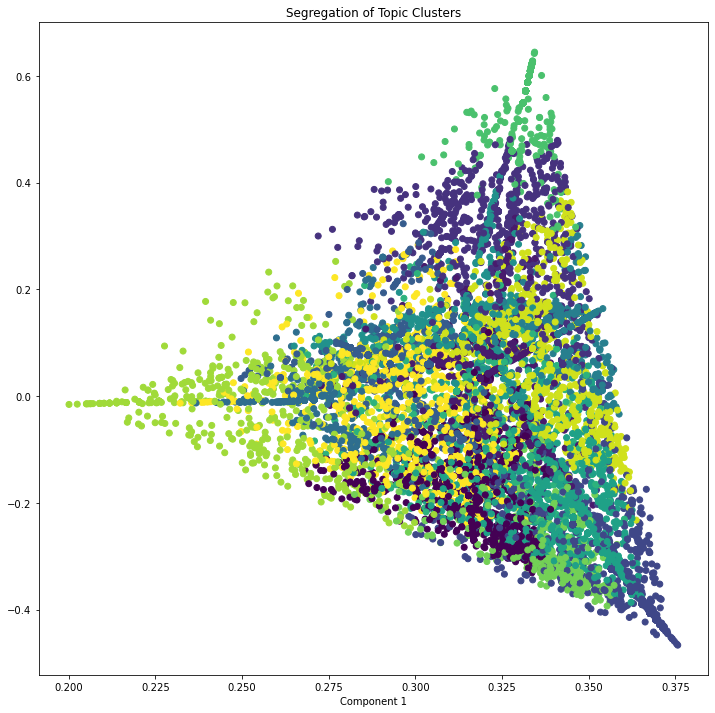

In [28]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

How to get similar documents for any given piece of text?
Once you know the probaility of topics for a given document (using predict_topic()), compute the euclidean distance with the probability scores of all other documents.

The most similar documents are the ones with the smallest distance.

In [29]:
from sklearn.metrics.pairwise import euclidean_distances

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def similar_documents(text, doc_topic_probs, documents = data, nlp=nlp, top_n=5, verbose=False):
    topic, x  = predict_topic(text)
    dists = euclidean_distances(x.reshape(1, -1), doc_topic_probs)[0]
    doc_ids = np.argsort(dists)[:top_n]
    if verbose:        
        print("Topic KeyWords: ", topic)
        print("Topic Prob Scores of text: ", np.round(x, 1))
        print("Most Similar Doc's Probs:  ", np.round(doc_topic_probs[doc_ids], 1))
    return doc_ids, np.take(documents, doc_ids)


# Get similar documents
mytext = ["Some text about christianity and bible"]
doc_ids, docs = similar_documents(text=mytext, doc_topic_probs=lda_output, documents = data, top_n=1, verbose=True)
print('\n', docs[0][:500])

C:\Users\sharv\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Topic KeyWords:  ['charge', 'work', 'phone', 'day', 'hour', 'charger', 'battery', 'service', 'turbo', 'time', 'use', 'mobile', 'properly', 'heat', 'product']
Topic Prob Scores of text:  [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.5 0.1 0.1]]
Most Similar Doc's Probs:   [[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.5 0.1 0.1]]

 camera quality superb battery also long lasting
